#### import all libraries

In [12]:
import time  # Used to measure execution time (e.g., training time)
import pandas as pd  # Used for loading and manipulating the dataset (DataFrame operations)
import warnings  # Used to control or hide warning messages during execution
import matplotlib.pyplot as plt  # Used for plotting graphs (loss curve, ROC curve, etc.)
from sklearn.exceptions import ConvergenceWarning  # Warning that occurs when Logistic Regression doesn't fully converge
warnings.filterwarnings("ignore", category=ConvergenceWarning)  
# Suppress convergence warnings to keep notebook output clean (common when max_iter is low or data is large)
from sklearn.model_selection import train_test_split  
# Used to split the dataset into training and testing sets (or train/val/test)
from sklearn.feature_extraction.text import TfidfVectorizer  
# Converts text data into numerical TF-IDF features that machine learning models can understand
from sklearn.metrics import log_loss  
# Computes log loss (cross-entropy loss) for evaluating probability-based classification models
from sklearn.linear_model import LogisticRegression  
# Logistic Regression model (baseline classifier for text classification)
from sklearn.metrics import (
    accuracy_score,          # Calculates overall accuracy (correct predictions / total predictions)
    classification_report,   # Gives precision, recall, F1-score for each class
    confusion_matrix,        # Shows correct vs incorrect predictions in matrix form
    roc_curve,               # Creates ROC curve points (FPR vs TPR)
    roc_auc_score            # Calculates AUC (area under ROC curve) to measure separability
)


#### Load preprocessed dataset

In [15]:
#Load dataset form preprocessed data.
df = pd.read_csv("disaster_tweets_preprocessed.csv")
df.head()

,Tweets,Disaster,Disaster_Label,clean_text,word_len
0,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,Non-Disaster,0,us drought monitor happy leap day for the stat...,35
1,Synonym is #Drought,Non-Disaster,0,synonym is drought,3
2,"Across South America in the last two months, #...",Disaster,1,across south america in the last two months fl...,29
3,Wildfires Going On In Texas #wildfires #texa...,Disaster,1,wildfires going on in texas wildfires texasfires,7
4,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,Non-Disaster,0,start your stand up comedy career for purchase...,23


#### Train-test split

In [18]:
# Prepare input features and target labels
X = df["clean_text"]
y = df["Disaster_Label"]
# Split the dataset into training and testing sets
# stratify=y ensures both sets keep the same class distribution
# random_state ensures reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train samples:", len(X_train))
print("Test samples :", len(X_test))


Train samples: 2047
Test samples : 512


In [20]:
# Handle missing values in text data
X_train = X_train.fillna("")
X_test  = X_test.fillna("")

#### TF-IDF vectorization

In [23]:
# Convert text data into numerical features using TF-IDF
# This helps reduce dimensionality and improves training efficiency
vectorizer = TfidfVectorizer(
    max_features=3000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)
# Display the shape of TF-IDF matrices
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape :", X_test_tfidf.shape)

TF-IDF Train shape: (2047, 3000)
TF-IDF Test shape : (512, 3000)


#### Train logistic regression (from scratch)

In [26]:
# Record the start time to measure training duration
start_time = time.time()

# Initialize the Logistic Regression model
# max_iter=2000 allows more iterations for convergence
# class_weight="balanced" handles class imbalance by assigning higher weight to minority classes
logreg_model = LogisticRegression(max_iter=2000, class_weight="balanced")

# Train (fit) the model using TF-IDF features and training label
logreg_model.fit(X_train_tfidf, y_train)

# Calculate total training time
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")


Training completed in 0.02 seconds


#### prediction and accuracy 

In [29]:
# Predict labels for the training data and testing data
train_pred = logreg_model.predict(X_train_tfidf)
test_pred  = logreg_model.predict(X_test_tfidf)

# Calculate accuracy on training data and testing data
train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test, test_pred)

# Check for overfitting or underfitting
print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)
if train_acc - test_acc > 0.1:
    print("Possible Overfitting detected")
elif train_acc < 0.6 and test_acc < 0.6:
    print("Possible Underfitting detected")
else:
    print("No major overfitting or underfitting")

Train Accuracy: 0.9653150952613581
Test Accuracy : 0.951171875
No major overfitting or underfitting


#### Confusion matrix 

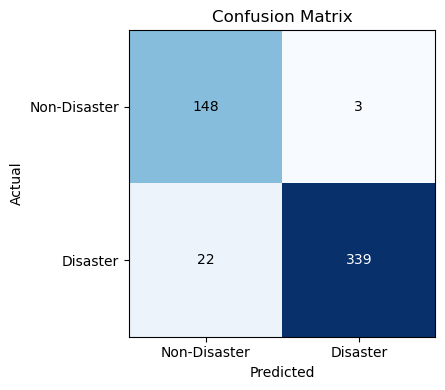

In [44]:
# Generate the confusion matrix using true labels and predicted labels
# Rows represent actual classes
# Columns represent predicted classes
cm = confusion_matrix(y_test, test_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Non-Disaster", "Disaster"])
plt.yticks([0,1], ["Non-Disaster", "Disaster"])
max_value = cm.max()
# Display values inside each cell
for i in range(2):
    for j in range(2):
        plt.text(
            j, i, 
            cm[i, j], 
            ha="center", 
            va="center", 
            color="white" if cm[i, j] == max_value else "black" )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### Roc curve

AUC Score: 0.9905707104987985


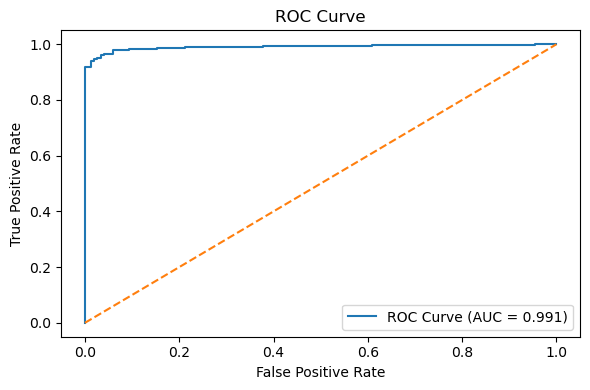

In [167]:
# Predict probability scores for the test data
# [:, 1] selects the probability of the positive class (Disaster = 1)
y_prob = logreg_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR),
# and threshold values for different classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Area Under the ROC Curve (AUC)
auc_score = roc_auc_score(y_test, y_prob)

print("AUC Score:", auc_score)

# Create a new figure for the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


#### Classification Report

In [169]:
train_acc_percent = train_acc * 100
test_acc_percent  = test_acc * 100

print(f"Train Accuracy: {train_acc_percent:.2f}%")
print(f"Test Accuracy : {test_acc_percent:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, test_pred))

Train Accuracy: 97.46%
Test Accuracy : 94.34%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       151
           1       0.94      0.99      0.96       361

    accuracy                           0.94       512
   macro avg       0.95      0.91      0.93       512
weighted avg       0.94      0.94      0.94       512



#### Split train - validation

In [173]:
# Split training data into train & validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_tfidf, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)


#### Train logistic regression (Epoch-by-Epoch)

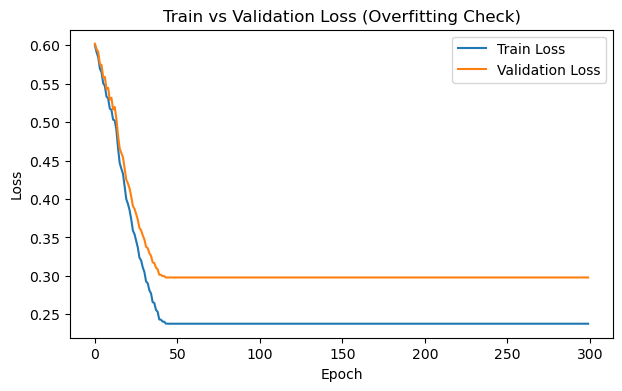

In [176]:
epochs = 300
model = LogisticRegression(
    max_iter=1,
    warm_start=True,
    solver="lbfgs"
)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.fit(X_tr, y_tr)

    y_tr_prob = model.predict_proba(X_tr)
    y_val_prob = model.predict_proba(X_val)

    train_losses.append(log_loss(y_tr, y_tr_prob))
    val_losses.append(log_loss(y_val, y_val_prob))

# Plot
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Train vs Validation Loss (Overfitting Check)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [47]:
import numpy as np

sample_sentences = [
    "Earthquake destroyed many houses and people are injured.",
    "I love this new movie, it was amazing!",
    "Landslide just happened in Kathmadu.",
    "Just finished my dinner and going to sleep now.",
    "Wildfire spreading fast due to strong winds."
]

# 0 = Non-Disaster, 1 = Disaster (you decide the ground truth)
actual_labels = [1, 0, 1, 0, 1]

label_names = {0: "Non-Disaster", 1: "Disaster"}

# 1) Vectorize text using your TF-IDF vectorizer
X_sample = vectorizer.transform(sample_sentences)

# 2) Predict class + probabilities
preds = logreg_model.predict(X_sample)
probs = logreg_model.predict_proba(X_sample)   # shape (5,2)

print("\nSample Predictions (Logistic Regression) — Actual + Predicted + Confidence\n")

for text, actual, pred, prob in zip(sample_sentences, actual_labels, preds, probs):
    confidence = prob[int(pred)] * 100
    print(f"Text: {text}")
    print(f"Actual:     {label_names[int(actual)]}")
    print(f"Predicted:  {label_names[int(pred)]} ({confidence:.2f}%)")
    print(f"Probabilities -> Non-Disaster: {prob[0]*100:.2f}% | Disaster: {prob[1]*100:.2f}%")
    print("-" * 70)



Sample Predictions (Logistic Regression) — Actual + Predicted + Confidence

Text: Earthquake destroyed many houses and people are injured.
Actual:     Disaster
Predicted:  Disaster (85.49%)
Probabilities -> Non-Disaster: 14.51% | Disaster: 85.49%
----------------------------------------------------------------------
Text: I love this new movie, it was amazing!
Actual:     Non-Disaster
Predicted:  Non-Disaster (51.69%)
Probabilities -> Non-Disaster: 51.69% | Disaster: 48.31%
----------------------------------------------------------------------
Text: Landslide just happened in Kathmadu.
Actual:     Disaster
Predicted:  Disaster (66.50%)
Probabilities -> Non-Disaster: 33.50% | Disaster: 66.50%
----------------------------------------------------------------------
Text: Just finished my dinner and going to sleep now.
Actual:     Non-Disaster
Predicted:  Non-Disaster (55.78%)
Probabilities -> Non-Disaster: 55.78% | Disaster: 44.22%
---------------------------------------------------------

In [50]:
import pickle

# Bundle everything required for inference
logreg_artifacts = {
    "model": logreg_model,     # trained Logistic Regression model
    "vectorizer": vectorizer  # fitted TF-IDF vectorizer
}

# Save to disk
with open("logistic_regression_disaster_model.pkl", "wb") as f:
    pickle.dump(logreg_artifacts, f)

print("Logistic Regression model saved successfully!")


Logistic Regression model saved successfully!
